# Latent Feature Extraction

## 1. Set up the Environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 1.2 MB 4.4 MB/s 


In [ ]:
import logging
import os
import sys
import shutil
import tempfile
import random
import time
import copy

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import pandas as pd

import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, CacheDataset, partition_dataset_classes

from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
    EnsureTyped,
    LoadImaged,
    AddChanneld,
    Orientationd,
    Resized,
    EnsureType,
    Activations,
    AsDiscrete
)

from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
device = torch.device("cuda")

In [ ]:
# set a random seed for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

## 2. Connect to Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

drive_dir = "/content/drive/My Drive"
mount_dir = os.path.join(drive_dir, "Colab Notebooks")
image_dir = os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data/T2_test_data/imagesTs")
weights_dir = os.path.join(mount_dir, "pretrained_models/MedicalNet_resnet")
results_dir = os.path.join(drive_dir, "Test Data")

Mounted at /content/drive


## 3. Create Train and Validation Dataset

In [ ]:
# specify transformations that are to be applied
transforms = Compose([
    LoadImaged(keys=["image"]),
    AddChanneld(keys=["image"]),
    Orientationd(keys=["image"], axcodes="PLI"),
    Resized(keys=["image"], spatial_size=(128, 128, 64)),
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image"])])

/usr/local/lib/python3.8/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
# Create labels
labels = np.concatenate((np.ones(20, dtype='int64'), np.zeros(20, dtype='int64')), axis=0)

# Get image paths
image_paths = [
  os.path.join(image_dir, img)
  for img in os.listdir(image_dir)
]

data = [{"image": i, "label": l} for i, l in zip(image_paths, labels)]

In [ ]:
# create 80:20 data split
data_partition = partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])

# create data loader object
datasets = {x: CacheDataset(data=data_partition[x], transform=transforms) for x in [0, 1]}
dataloaders_dict = {x: DataLoader(datasets[x], batch_size=8, shuffle=True, num_workers=4) for x in [0, 1]}

# rename dict of data loader object
dataloaders_dict['train'] = dataloaders_dict.pop(0)
dataloaders_dict['val'] = dataloaders_dict.pop(1)

Loading dataset: 100%|██████████| 8/8 [00:01<00:00,  6.26it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 4. Define Network Architecture

In [ ]:
class ResNet50(torch.nn.Module):
    def __init__(self, num_classes, pretrained = False, features_extract = False):
        super().__init__()

        # load 3d ResNet
        self.model = monai.networks.nets.resnet50(spatial_dims=3, n_input_channels=1)
        if pretrained:
          model_dict = self.model.state_dict()

          # load pretrained MedicalNet weights
          weights_dict = torch.load(os.path.join(weights_dir, "resnet_50_23dataset.pth"))
          
          # rename modules in weight dict
          weights_dict = {k.replace('module.', ''): v for k, v in weights_dict['state_dict'].items()}

          # update model weights with pretrained weights
          model_dict.update(weights_dict)
          self.model.load_state_dict(model_dict)
        
        # freeze model weights
        if features_extract:
          conv_block = 0
          for child in self.model.children():
            conv_block += 1
            if conv_block < 8:
              for param in child.parameters():
                param.requires_grad = False
            #elif conv_block == 8:
             # layer = 0
              #for children_of_child in child.children():
               # layer += 1
                #if layer < 3:
                 # for param in children_of_child.parameters():
                  #  param.requires_grad = False

        # create custom fc layers
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Identity()

        self.features = torch.nn.Linear(num_ftrs, 128)
        self.classifier = torch.nn.Linear(128, num_classes)
    
    def forward(self, image):

        # define forward pass
        x = self.model(image)
        x = self.features(x)
        x = self.classifier(x)
        
        return x

## 5. Initialize the Network with Pretrained Weights

In [ ]:
# Number of classes in the dataset
num_classes = 2

# Flag to indicate whether model should be initialized with pretrained weights
pretrained = True

# Flag to indicate whether only a set of weights should be updated. If False
# the entire model is finetuned
feature_extract = True

In [ ]:
# Initialize the model for this run
model_ft = ResNet50(num_classes, pretrained, feature_extract)

# add model to GPU
model_ft = model_ft.to(device)

## 6. Specify Parameters that Should Be Finetuned  

In [ ]:
# Gather the parameters to be optimized/updated in this run
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 model.layer4.0.conv1.weight
	 model.layer4.0.bn1.weight
	 model.layer4.0.bn1.bias
	 model.layer4.0.conv2.weight
	 model.layer4.0.bn2.weight
	 model.layer4.0.bn2.bias
	 model.layer4.0.conv3.weight
	 model.layer4.0.bn3.weight
	 model.layer4.0.bn3.bias
	 model.layer4.0.downsample.0.weight
	 model.layer4.0.downsample.0.bias
	 model.layer4.0.downsample.1.weight
	 model.layer4.0.downsample.1.bias
	 model.layer4.1.conv1.weight
	 model.layer4.1.bn1.weight
	 model.layer4.1.bn1.bias
	 model.layer4.1.conv2.weight
	 model.layer4.1.bn2.weight
	 model.layer4.1.bn2.bias
	 model.layer4.1.conv3.weight
	 model.layer4.1.bn3.weight
	 model.layer4.1.bn3.bias
	 model.layer4.2.conv1.weight
	 model.layer4.2.bn1.weight
	 model.layer4.2.bn1.bias
	 model.layer4.2.conv2.weight
	 model.layer4.2.bn2.weight
	 model.layer4.2.bn2.bias
	 model.layer4.2.conv3.weight
	 model.layer4.2.bn3.weight
	 model.layer4.2.bn3.bias
	 features.weight
	 features.bias
	 classifier.weight
	 classifier.bias


## 7. Finetune the Network

In [ ]:
# Specify the loss function
criterion = torch.nn.CrossEntropyLoss()

# Specify the learning rate
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, min_epochs=50, early_stop=False):
    since = time.time()

    # create empty storage
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    acc = 0.0
    prec = 0.0
    recall = 0.0
    fscore = 0.0
    best_loss = 10000.0
    counter = 0

    for epoch in range(min_epochs + 10 * min_epochs):
        print('Epoch {}'.format(epoch))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_data in dataloaders[phase]:
                inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc.item()))

            # safe training loss and accuracy
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                acc = epoch_acc
                prec = precision_score(labels.cpu(), preds.cpu())
                recall = recall_score(labels.cpu(), preds.cpu())
                fscore = f1_score(labels.cpu(), preds.cpu())
                counter = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            elif phase == 'val' and epoch_loss >= best_loss:
                counter += 1

            # safe validation loss and accuracy
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc) 

        print()

        # introduce early stopping
        if early_stop == True:
            if epoch > min_epochs - 1 and counter == 10:
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('val Acc: {:4f} Precision: {:4f} Recall: {:4f} F1-Score: {:4f}'.format(acc.item(), prec.item(), recall.item(), fscore.item()))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # save best model weights
    torch.save(model.state_dict(best_model_wts), os.path.join(results_dir, 'best_model.pth'))

    return model, val_loss_history, val_acc_history, train_loss_history, train_acc_history

In [ ]:
# Minimum number of epochs to train for
min_epochs = 50

# Flag to indicate whether early stopping should be used
early_stop = True

In [ ]:
# Train and evaluate
model_ft, val_loss_hist, val_acc_hist, train_loss_hist, train_acc_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, min_epochs=min_epochs, early_stop=early_stop)

Epoch 0
----------
train Loss: 0.7060 Acc: 0.5000
val Loss: 0.6959 Acc: 0.5000

Epoch 1
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7017 Acc: 0.5000
val Loss: 0.6937 Acc: 0.5000

Epoch 2
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.7070 Acc: 0.5000
val Loss: 0.6934 Acc: 0.5000

Epoch 3
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6989 Acc: 0.5000
val Loss: 0.6931 Acc: 0.5000

Epoch 4
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6845 Acc: 0.5312
val Loss: 0.6932 Acc: 0.5000

Epoch 5
----------
train Loss: 0.6947 Acc: 0.5312
val Loss: 0.6930 Acc: 0.5000

Epoch 6
----------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6931 Acc: 0.5312
val Loss: 0.6936 Acc: 0.5000

Epoch 7
----------
train Loss: 0.6877 Acc: 0.5000
val Loss: 0.6929 Acc: 0.5000

Epoch 8
----------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6832 Acc: 0.6250
val Loss: 0.6928 Acc: 0.5000

Epoch 9
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6838 Acc: 0.6250
val Loss: 0.6929 Acc: 0.5000

Epoch 10
----------
train Loss: 0.6756 Acc: 0.6250
val Loss: 0.6932 Acc: 0.5000

Epoch 11
----------
train Loss: 0.6907 Acc: 0.5000
val Loss: 0.6924 Acc: 0.5000

Epoch 12
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6768 Acc: 0.5000
val Loss: 0.6906 Acc: 0.5000

Epoch 13
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6738 Acc: 0.6250
val Loss: 0.6893 Acc: 0.6250

Epoch 14
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6821 Acc: 0.5000
val Loss: 0.6880 Acc: 0.5000

Epoch 15
----------


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6940 Acc: 0.6562
val Loss: 0.6858 Acc: 0.5000

Epoch 16
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6652 Acc: 0.7500
val Loss: 0.6834 Acc: 0.6250

Epoch 17
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6674 Acc: 0.7500
val Loss: 0.6805 Acc: 0.5000

Epoch 18
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6623 Acc: 0.7500
val Loss: 0.6783 Acc: 0.5000

Epoch 19
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6695 Acc: 0.6250
val Loss: 0.6768 Acc: 0.5000

Epoch 20
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6536 Acc: 0.7188
val Loss: 0.6751 Acc: 0.5000

Epoch 21
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6565 Acc: 0.5625
val Loss: 0.6742 Acc: 0.5000

Epoch 22
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6689 Acc: 0.6250
val Loss: 0.6702 Acc: 0.8750

Epoch 23
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6618 Acc: 0.7500
val Loss: 0.6687 Acc: 0.8750

Epoch 24
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6587 Acc: 0.7188
val Loss: 0.6665 Acc: 0.8750

Epoch 25
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6422 Acc: 0.7812
val Loss: 0.6664 Acc: 0.8750

Epoch 26
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6600 Acc: 0.7812
val Loss: 0.6648 Acc: 0.8750

Epoch 27
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6520 Acc: 0.8750
val Loss: 0.6616 Acc: 0.8750

Epoch 28
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6736 Acc: 0.7500
val Loss: 0.6608 Acc: 0.8750

Epoch 29
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6585 Acc: 0.7500
val Loss: 0.6588 Acc: 0.8750

Epoch 30
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6413 Acc: 0.7500
val Loss: 0.6615 Acc: 0.5000

Epoch 31
----------
train Loss: 0.6840 Acc: 0.5938
val Loss: 0.6629 Acc: 0.5000

Epoch 32
----------
train Loss: 0.6535 Acc: 0.5625
val Loss: 0.6577 Acc: 0.8750

Epoch 33
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6564 Acc: 0.7812
val Loss: 0.6565 Acc: 0.7500

Epoch 34
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6309 Acc: 0.7812
val Loss: 0.6549 Acc: 0.6250

Epoch 35
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6382 Acc: 0.7500
val Loss: 0.6501 Acc: 0.8750

Epoch 36
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6439 Acc: 0.7500
val Loss: 0.6489 Acc: 0.8750

Epoch 37
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6269 Acc: 0.8438
val Loss: 0.6497 Acc: 0.7500

Epoch 38
----------
train Loss: 0.6428 Acc: 0.6875
val Loss: 0.6499 Acc: 0.5000

Epoch 39
----------
train Loss: 0.6315 Acc: 0.7500
val Loss: 0.6501 Acc: 0.5000

Epoch 40
----------
train Loss: 0.6499 Acc: 0.5625
val Loss: 0.6503 Acc: 0.5000

Epoch 41
----------
train Loss: 0.6871 Acc: 0.6250
val Loss: 0.6420 Acc: 0.8750

Epoch 42
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6324 Acc: 0.7500
val Loss: 0.6429 Acc: 0.8750

Epoch 43
----------
train Loss: 0.6531 Acc: 0.7812
val Loss: 0.6423 Acc: 0.8750

Epoch 44
----------
train Loss: 0.6433 Acc: 0.7188
val Loss: 0.6377 Acc: 0.8750

Epoch 45
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6008 Acc: 0.7812
val Loss: 0.6349 Acc: 0.8750

Epoch 46
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6079 Acc: 0.9062
val Loss: 0.6337 Acc: 0.8750

Epoch 47
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6000 Acc: 0.8438
val Loss: 0.6318 Acc: 0.7500

Epoch 48
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6020 Acc: 0.8750
val Loss: 0.6294 Acc: 0.8750

Epoch 49
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5950 Acc: 0.8125
val Loss: 0.6265 Acc: 0.8750

Epoch 50
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6088 Acc: 0.8750
val Loss: 0.6225 Acc: 0.7500

Epoch 51
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6306 Acc: 0.8125
val Loss: 0.6231 Acc: 0.8750

Epoch 52
----------
train Loss: 0.6100 Acc: 0.7812
val Loss: 0.6167 Acc: 0.8750

Epoch 53
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5903 Acc: 0.8125
val Loss: 0.6146 Acc: 0.8750

Epoch 54
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6002 Acc: 0.7500
val Loss: 0.6108 Acc: 0.8750

Epoch 55
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6152 Acc: 0.7188
val Loss: 0.6122 Acc: 0.8750

Epoch 56
----------
train Loss: 0.6004 Acc: 0.8438
val Loss: 0.6121 Acc: 0.8750

Epoch 57
----------
train Loss: 0.5880 Acc: 0.8750
val Loss: 0.6117 Acc: 0.8750

Epoch 58
----------
train Loss: 0.5868 Acc: 0.7188
val Loss: 0.6119 Acc: 0.8750

Epoch 59
----------
train Loss: 0.5779 Acc: 0.8438
val Loss: 0.6022 Acc: 0.8750

Epoch 60
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5351 Acc: 0.8438
val Loss: 0.5951 Acc: 0.8750

Epoch 61
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5672 Acc: 0.8438
val Loss: 0.5928 Acc: 0.8750

Epoch 62
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5894 Acc: 0.8125
val Loss: 0.5969 Acc: 0.8750

Epoch 63
----------
train Loss: 0.6041 Acc: 0.7500
val Loss: 0.6067 Acc: 0.5000

Epoch 64
----------
train Loss: 0.5724 Acc: 0.6875
val Loss: 0.5956 Acc: 0.8750

Epoch 65
----------
train Loss: 0.5771 Acc: 0.8750
val Loss: 0.5904 Acc: 0.8750

Epoch 66
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5757 Acc: 0.7500
val Loss: 0.5872 Acc: 0.8750

Epoch 67
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5517 Acc: 0.8438
val Loss: 0.5788 Acc: 0.7500

Epoch 68
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5816 Acc: 0.7500
val Loss: 0.5803 Acc: 0.7500

Epoch 69
----------
train Loss: 0.5991 Acc: 0.7500
val Loss: 0.5760 Acc: 0.8750

Epoch 70
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5520 Acc: 0.8438
val Loss: 0.5735 Acc: 0.7500

Epoch 71
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5343 Acc: 0.8750
val Loss: 0.5648 Acc: 0.7500

Epoch 72
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5342 Acc: 0.7812
val Loss: 0.5584 Acc: 0.7500

Epoch 73
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5622 Acc: 0.8125
val Loss: 0.5556 Acc: 0.8750

Epoch 74
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5292 Acc: 0.8125
val Loss: 0.5556 Acc: 0.8750

Epoch 75
----------
train Loss: 0.5364 Acc: 0.7812
val Loss: 0.5484 Acc: 0.8750

Epoch 76
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5059 Acc: 0.8438
val Loss: 0.5346 Acc: 0.7500

Epoch 77
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5040 Acc: 0.8438
val Loss: 0.5319 Acc: 0.7500

Epoch 78
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.5314 Acc: 0.8125
val Loss: 0.5295 Acc: 0.8750

Epoch 79
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4874 Acc: 0.8750
val Loss: 0.5226 Acc: 0.7500

Epoch 80
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4601 Acc: 0.9375
val Loss: 0.5164 Acc: 0.7500

Epoch 81
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4466 Acc: 0.8438
val Loss: 0.5110 Acc: 0.7500

Epoch 82
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4704 Acc: 0.8750
val Loss: 0.5025 Acc: 0.8750

Epoch 83
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4920 Acc: 0.9062
val Loss: 0.5011 Acc: 0.7500

Epoch 84
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4774 Acc: 0.8750
val Loss: 0.4941 Acc: 0.7500

Epoch 85
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4760 Acc: 0.8438
val Loss: 0.4839 Acc: 0.7500

Epoch 86
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4319 Acc: 0.8750
val Loss: 0.4730 Acc: 0.7500

Epoch 87
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4500 Acc: 0.8438
val Loss: 0.4682 Acc: 0.8750

Epoch 88
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4045 Acc: 0.9062
val Loss: 0.4644 Acc: 0.8750

Epoch 89
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3928 Acc: 0.8750
val Loss: 0.4579 Acc: 0.8750

Epoch 90
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3996 Acc: 0.8750
val Loss: 0.4449 Acc: 0.7500

Epoch 91
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4336 Acc: 0.8750
val Loss: 0.4381 Acc: 0.8750

Epoch 92
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4214 Acc: 0.8125
val Loss: 0.4295 Acc: 0.7500

Epoch 93
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3906 Acc: 0.9062
val Loss: 0.4254 Acc: 0.7500

Epoch 94
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3624 Acc: 0.8750
val Loss: 0.4223 Acc: 0.7500

Epoch 95
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3890 Acc: 0.8438
val Loss: 0.4140 Acc: 0.7500

Epoch 96
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3801 Acc: 0.8750
val Loss: 0.4163 Acc: 0.7500

Epoch 97
----------
train Loss: 0.3413 Acc: 0.9062
val Loss: 0.4079 Acc: 0.7500

Epoch 98
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3689 Acc: 0.8125
val Loss: 0.4016 Acc: 0.7500

Epoch 99
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3253 Acc: 0.8438
val Loss: 0.3893 Acc: 0.7500

Epoch 100
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3161 Acc: 0.9375
val Loss: 0.3835 Acc: 0.7500

Epoch 101
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3359 Acc: 0.9375
val Loss: 0.3855 Acc: 0.7500

Epoch 102
----------
train Loss: 0.4840 Acc: 0.7812
val Loss: 0.3754 Acc: 0.7500

Epoch 103
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3085 Acc: 0.9062
val Loss: 0.3652 Acc: 0.7500

Epoch 104
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3739 Acc: 0.9375
val Loss: 0.3634 Acc: 0.7500

Epoch 105
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2882 Acc: 0.9688
val Loss: 0.3585 Acc: 0.7500

Epoch 106
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3613 Acc: 0.9062
val Loss: 0.3606 Acc: 0.7500

Epoch 107
----------
train Loss: 0.3156 Acc: 0.8750
val Loss: 0.3578 Acc: 0.7500

Epoch 108
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.4043 Acc: 0.7812
val Loss: 0.3504 Acc: 0.7500

Epoch 109
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3638 Acc: 0.8438
val Loss: 0.3429 Acc: 0.7500

Epoch 110
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2796 Acc: 0.8750
val Loss: 0.3396 Acc: 0.7500

Epoch 111
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2882 Acc: 0.8750
val Loss: 0.3368 Acc: 0.7500

Epoch 112
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3648 Acc: 0.8125
val Loss: 0.3365 Acc: 0.7500

Epoch 113
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2448 Acc: 0.9062
val Loss: 0.3383 Acc: 0.7500

Epoch 114
----------
train Loss: 0.2549 Acc: 0.9375
val Loss: 0.3404 Acc: 0.7500

Epoch 115
----------
train Loss: 0.2193 Acc: 0.9375
val Loss: 0.3432 Acc: 0.7500

Epoch 116
----------
train Loss: 0.3383 Acc: 0.8438
val Loss: 0.3375 Acc: 0.7500

Epoch 117
----------
train Loss: 0.1993 Acc: 0.9688
val Loss: 0.3373 Acc: 0.7500

Epoch 118
----------
train Loss: 0.2297 Acc: 0.8750
val Loss: 0.3347 Acc: 0.7500

Epoch 119
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.2990 Acc: 0.8750
val Loss: 0.3327 Acc: 0.7500

Epoch 120
----------


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.3157 Acc: 0.8438
val Loss: 0.3340 Acc: 0.7500

Epoch 121
----------
train Loss: 0.2239 Acc: 0.8750
val Loss: 0.3385 Acc: 0.7500

Epoch 122
----------
train Loss: 0.2213 Acc: 0.9062
val Loss: 0.3460 Acc: 0.7500

Epoch 123
----------
train Loss: 0.1726 Acc: 0.9375
val Loss: 0.3380 Acc: 0.7500

Epoch 124
----------
train Loss: 0.2040 Acc: 0.9062
val Loss: 0.3389 Acc: 0.7500

Epoch 125
----------
train Loss: 0.2328 Acc: 0.9375
val Loss: 0.3430 Acc: 0.7500

Epoch 126
----------
train Loss: 0.1689 Acc: 0.9688
val Loss: 0.3373 Acc: 0.7500

Epoch 127
----------
train Loss: 0.2514 Acc: 0.8750
val Loss: 0.3423 Acc: 0.7500

Epoch 128
----------
train Loss: 0.1635 Acc: 0.9062
val Loss: 0.3535 Acc: 0.7500

Epoch 129
----------
train Loss: 0.1880 Acc: 0.9375
val Loss: 0.3438 Acc: 0.7500

Training complete in 17m 18s
val Acc: 0.750000 Precision: 0.750000 Recall: 0.750000 F1-Score: 0.750000


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1428: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


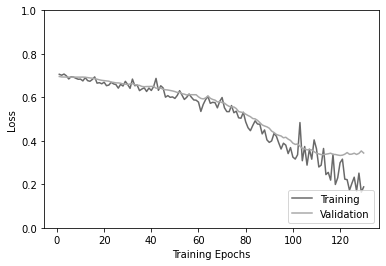

In [ ]:
# Plot the training curves of validation accuracy vs. number of training epochs 
train_loss = []
train_loss = [epoch for epoch in train_loss_hist]

val_loss = []
val_loss = [epoch for epoch in val_loss_hist]

#plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, 131), train_loss, color="dimgray", label="Training")
plt.plot(range(1, 131), val_loss, color="darkgray", label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(0, 131, 20))
plt.legend(loc="lower right")

plt.savefig(os.path.join(results_dir, 'loss_hist.png'), dpi=300)

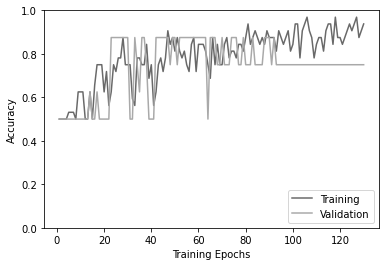

In [ ]:
# Plot the training curves of validation accuracy vs. number of training epochs 
train_acc = []
train_acc = [epoch.cpu().numpy() for epoch in train_acc_hist]

val_acc = []
val_acc = [epoch.cpu().numpy() for epoch in val_acc_hist]

#plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, 131), train_acc, color="dimgray", label="Training")
plt.plot(range(1, 131), val_acc, color="darkgray", label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(0, 131, 20))
plt.legend(loc="lower right")

plt.savefig(os.path.join(results_dir, 'acc_hist.png'), dpi=300)

## 8. Extract Latent Features from Finetuned Model

In [ ]:
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

In [ ]:
# set hook at layer where features should be extracted
model_ft.features.register_forward_hook(get_features('feats'))

In [ ]:
# placeholders
labels = []
pred = []
feats = []
img_path = []

# placeholder for batch features
features = {}

# loop through batches
for phase in ['train', 'val']:
  for batch_data in dataloaders_dict[phase]:
    # move to device
    fname = batch_data["image_meta_dict"]["filename_or_obj"]
    inputs = batch_data["image"].to(device)
    targets = batch_data["label"].to(device)
       
    # forward pass [with feature extraction]
    preds = model_ft(inputs)
    
    # add feats and preds to lists
    img_path.extend(fname)
    labels.append(targets.detach().cpu().numpy())
    feats.append(features['feats'].cpu().numpy())

In [ ]:
feats_ft = np.concatenate(feats)
feats_ft.shape # 128 features

(40, 128)

In [ ]:
labels_ft = np.concatenate(labels)
labels_ft.shape

(40,)

In [ ]:
img_path = [path.replace(image_dir + '/', '') for path in img_path]
img_path = [path.replace('_0000.nii.gz', '') for path in img_path]

## 9. Write Feature Matrix to csv File

In [ ]:
# merge labels and features into a dataframe
ids = pd.DataFrame(img_path, columns=['id'])
labels = pd.DataFrame(labels_ft, columns=['HCC'])
deep_feats = pd.DataFrame(feats_ft, 
                          columns = ["var%d" % (i + 1) 
                          for i in range(feats_ft.shape[1])])

deep_feats = pd.concat([ids.reset_index(drop=True), labels, deep_feats], axis=1)

# write dataframe to csv
deep_feats.to_csv(os.path.join(results_dir, 'DeepFeaturesNew.csv'), index=False, header=True, sep=',')

## 10. Get Bootstrapped Performance Metrics

In [ ]:
# create storage
metric_acc = []
metric_prec = []
metric_recall = []
metric_fscore = []

# load best model weights
best_model = os.path.join(results_dir, 'best_model.pth')
model_ft.load_state_dict(torch.load(best_model))

# set model to evaluation mode
model_ft.eval()

for iter in range(1000):
    # resample validation set with replacement
    boot_data = resample(data_partition[1], replace=True, n_samples=16, random_state=iter)
    
    # apply transformations and create dataloader object
    val_set = CacheDataset(data=boot_data, transform=transforms)
    val_dataloader = DataLoader(val_set, batch_size=16, num_workers=4)
    
    with torch.no_grad():
        # loop over batch over resampled images
        for batch_data in val_dataloader:
            images, labels = batch_data['image'].to(device), batch_data['label'].to(device)
            # make predictions
            preds = model_ft(images).argmax(dim=1)

            # compute performance metrics
            acc = accuracy_score(labels.cpu(), preds.cpu())
            prec = precision_score(labels.cpu(), preds.cpu())
            recall = recall_score(labels.cpu(), preds.cpu())
            fscore = f1_score(labels.cpu(), preds.cpu())

            # store results
            metric_acc.append(acc)
            metric_prec.append(prec)
            metric_recall.append(recall)
            metric_fscore.append(fscore)

Loading dataset: 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid

In [ ]:
def get_confidence_interval(boot_estimates):
  mean = np.mean(boot_estimates, axis=0)
  std = 2*np.std(boot_estimates, axis=0)
  upper = np.clip(mean+std, 0, 1)
  lower = mean-std

  return mean, lower, upper

In [ ]:
# compute confidence interval
get_confidence_interval(metric_acc) # accuracy = 0.752 [0.545, 0.959]
get_confidence_interval(metric_prec) # precision = 0.746 [0.445, 1.000]
get_confidence_interval(metric_recall) # recall = 0.756 [0.452, 1.000]
get_confidence_interval(metric_fscore) # f1-score = 0.740 [0.495, 0.984]

(0.7461083277833277, 0.44483311686949145, 1.0)